# Optimization of the hydrophone placement

This notebook shows how to run the simulated annealing script to define the hydrophone configuration that minimizes localization uncertainties.

This notebook shows the example from the paper where we are trying to optimize the placement of 6 hydrophones in a 2m<sup>3</sup> volume. This notebook can however be used to optimize the placement of any number of hydrophones with different volume constraints (you will just need to change the input parameters).

## Import libraries

Let's first import all the libraries we will need. The libraries *simulated_annealing*, *localization*, and *tools* are in this GitHub repo. All the other libraries are shipped with python.

In [7]:
import simulated_annealing as sa
import localization
import tools
import pandas as pd
import pickle
import datetime
import os
import numpy as np
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

## Definition of the optimization parameters

In this section we define all the hydrophones configurations, contraints, and optimization parameters.

### Output folder
This is were the optimization results and figures will be saved.

In [8]:
outroot = r'.\simulated_annealing_results'

### Virtual sources
Here we define the coordinates of vortual sources. This is important as it defines what should be optimized. Here, we place 500 virtual sources (*nsources*) equally reparted (i.e., every *spacing* = 0.5 m) in a sphere of 2m radius (*radius*) centered on the middle of the array (*origin*). The goal of the optimization will be to find a hydrophone placement that minimizes the global localization uncertainties for all these sources. You can change the number and location of these sources to optimize your array differently (e.g., place sources only in the field of view of the cameras to optimization in this specific volume)

In [9]:
## Spherical grid (sources location)
nsources = 500
radius = 2
origin = [0, 0, 0]
spacing = 0.5

### Localization parameters
Here, we define the standard deviation of the data errors (*NoiseSTD*) and the sound speed (*V*). These values need to be defined to calculate localization uncertainties but actually won't impact the optimization results (i.e. the optimal hydrophone placement).  

In [10]:
# Measurements errors (TDOA)
NoiseSTD = 5.0714e-04  # standard deviation of TDOAs in s

# Sound speed (m/s)
V = 1488

### Hydrophone constraints
Here, we define the number of hydrophones (*nReceivers*) of the array we want to optimize and the volume in which they are "allowed" to move. In this example, our array has 6 hydrophones, and we allows them to be placed in a 2m<sup>3</sup> cubic volume (i.e., the x, y, and z coordinates of each hydrophone must be between -1m and 1m from the center). Note that you can change the boundaries of each hydrophone in the *ReceiverBounds* dataframe to reflect which ever space contraints you have. 

In [11]:
# Number of receivers (for optimization)
nReceivers = 6

# Receivers boundaries
ReceiverBoundValue = 1
tmp = [[-ReceiverBoundValue, ReceiverBoundValue]] * nReceivers  # boundaries of receiver location (m)
ReceiverBounds = pd.DataFrame({'x': tmp, 'y': tmp, 'z': tmp})

### Annealing schedule
This is where we define the parameters of the simulated annealing process:
- *Start*: Starting annealing temperature. 
- *ReducFactor*: Factor used to decrease the annealing temperature between consecutive iterations. Set closer to 1 for hard problems.
- *nPerturb*: Number of hydrophone locations tested at each iteration
- *PerturbSTD*: Used to find a new hydrophone location
- *StartAcceptanceRate*: Minimum acceptance rate for the first iteration (i.e. melting phase). If not achieved, the process will stop. You can increase the starting temperature (*Start*) until this condition is met. 
- *StopAcceptanceRate*: Acceptance rate at which the optimization process is stopped.
- *StopCost*: The process end when the cost value reaches StopCost.


In [13]:
# defines annealing schedule
AnnealingSchedule = ({          
    'Start': 200, 
    'ReducFactor': 0.95,
    'nPerturb': 100, 
    'PerturbSTD': 1/8,  
    'StartAcceptanceRate': 0.8, 
    'StopAcceptanceRate': 0.001,
    'StopCost': 0
     })

## Start simulated annealing process

This section goes through the simulated annealing optimization process. Optimization results are saved in a pickle file. It also plots and saves graphs of the annealing temperatures, acceptance rates, and hydrophone positions.

In [14]:
# prelim
NoiseVariance = NoiseSTD**2

# Set virtual sources location (spherical grid)
S = tools.defineSphereSurfaceGrid(nsources, radius, origin)
#S = tools.defineCubeVolumeGrid(spacing, radius, origin) # for cubic grid instead
S = S.to_numpy()
nsources = S.shape[0]

# creates output folder
StartTimestamp_obj = datetime.datetime.now()
StartTimestamp_str = StartTimestamp_obj.strftime("%Y%m%d%H%M%S")
outdir = os.path.join(outroot,StartTimestamp_str + '_' + 'Receivers' + str(nReceivers) + '_' + 'Bounds' + str(ReceiverBoundValue) + 'm_' + 'Sources' + str(nsources)  + '_' + 'Radius' + str(radius) + 'm' )
os.makedirs(outdir)

# Define receiver pairs for TDOAs
Rpairs = localization.defineReceiverPairs(nReceivers)
Rpairs = np.array(Rpairs)

# Optimize array configuration 
R, Rchanges, acceptRateChanges, Cost, processingTime = sa.optimizeArray(ReceiverBounds, nReceivers, AnnealingSchedule, S, Rpairs, V, NoiseVariance)       

Temperature: 200.000 - Acceptance rate: 0.88 - Cost: 10.26
Melting temperature valid (0.88).
Temperature: 190.000 - Acceptance rate: 0.87 - Cost: 9.72
Temperature: 180.500 - Acceptance rate: 0.90 - Cost: 12.27
Temperature: 171.475 - Acceptance rate: 0.90 - Cost: 10.43
Temperature: 162.901 - Acceptance rate: 0.95 - Cost: 25.10
Temperature: 154.756 - Acceptance rate: 0.95 - Cost: 8.51
Temperature: 147.018 - Acceptance rate: 0.88 - Cost: 7.44
Temperature: 139.667 - Acceptance rate: 0.86 - Cost: 6.36
Temperature: 132.684 - Acceptance rate: 0.84 - Cost: 8.42
Temperature: 126.050 - Acceptance rate: 0.82 - Cost: 6.72
Temperature: 119.747 - Acceptance rate: 0.91 - Cost: 7.91
Temperature: 113.760 - Acceptance rate: 0.87 - Cost: 7.87
Temperature: 108.072 - Acceptance rate: 0.89 - Cost: 7.03
Temperature: 102.668 - Acceptance rate: 0.87 - Cost: 5.78
Temperature: 97.535 - Acceptance rate: 0.88 - Cost: 8.70
Temperature: 92.658 - Acceptance rate: 0.96 - Cost: 10.21
Temperature: 88.025 - Acceptance ra

Temperature: 0.124 - Acceptance rate: 0.57 - Cost: 2.85
Temperature: 0.118 - Acceptance rate: 0.56 - Cost: 2.98
Temperature: 0.112 - Acceptance rate: 0.60 - Cost: 3.49
Temperature: 0.106 - Acceptance rate: 0.55 - Cost: 2.80
Temperature: 0.101 - Acceptance rate: 0.53 - Cost: 2.60
Temperature: 0.096 - Acceptance rate: 0.59 - Cost: 2.12
Temperature: 0.091 - Acceptance rate: 0.49 - Cost: 2.80
Temperature: 0.087 - Acceptance rate: 0.57 - Cost: 2.70
Temperature: 0.082 - Acceptance rate: 0.49 - Cost: 3.03
Temperature: 0.078 - Acceptance rate: 0.53 - Cost: 2.89
Temperature: 0.074 - Acceptance rate: 0.54 - Cost: 2.46
Temperature: 0.070 - Acceptance rate: 0.56 - Cost: 2.50
Temperature: 0.067 - Acceptance rate: 0.41 - Cost: 2.39
Temperature: 0.064 - Acceptance rate: 0.46 - Cost: 2.23
Temperature: 0.060 - Acceptance rate: 0.45 - Cost: 2.19
Temperature: 0.057 - Acceptance rate: 0.41 - Cost: 2.64
Temperature: 0.055 - Acceptance rate: 0.51 - Cost: 2.53
Temperature: 0.052 - Acceptance rate: 0.42 - Cos

## Plot results

### Evolution of the hydrophone coordinates

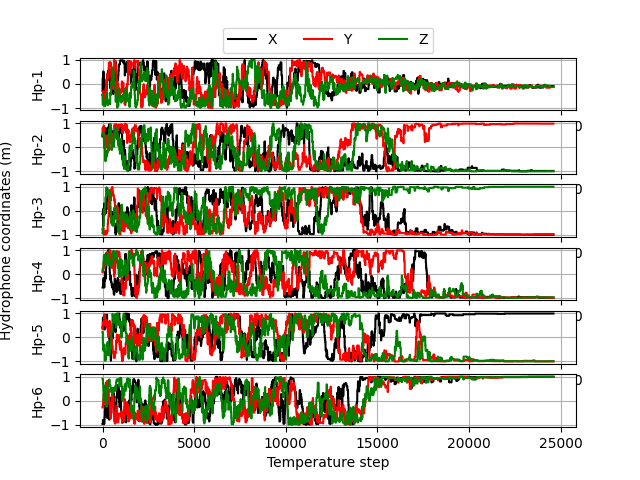

In [15]:
fig1 = sa.plotOptimizationResults_coords(outdir, nReceivers, Rchanges)
fig1.show()

### Evolution of the overall cost

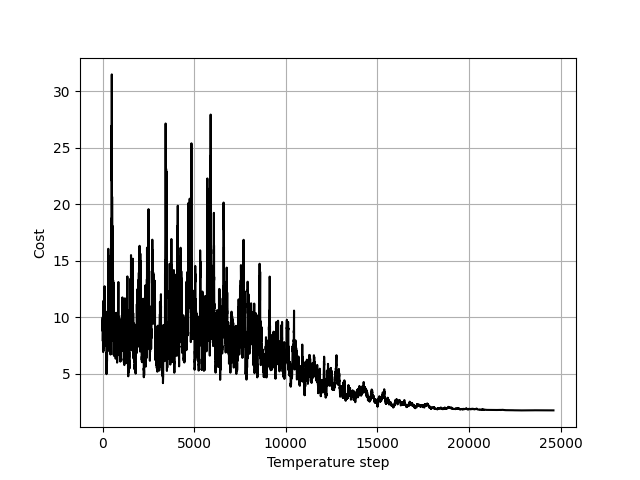

In [16]:
fig2 = sa.plotOptimizationResults_cost(outdir, Cost)
fig2.show()

### Evolution of the acceptance rate

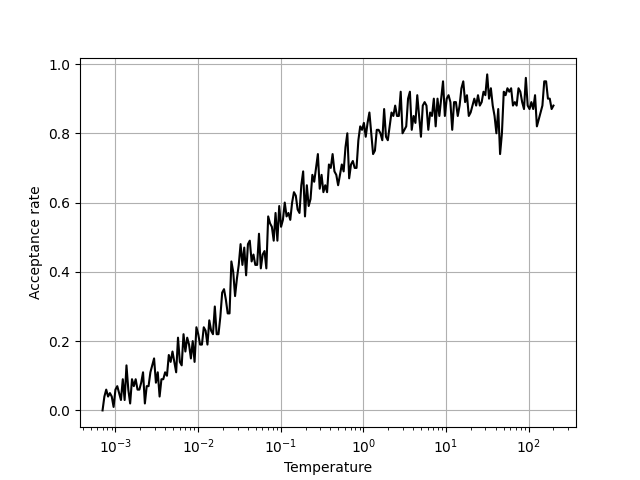

In [17]:
fig3 = sa.plotOptimizationResults_accRate(outdir, acceptRateChanges)
fig3.show()

### Final hydrophone positions

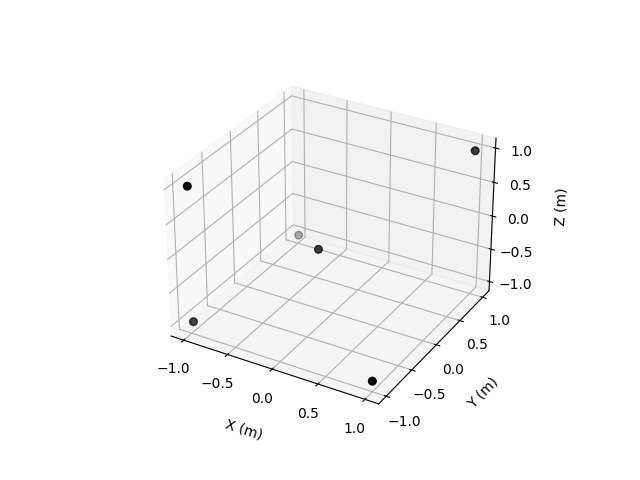

In [18]:
fig4 = sa.plotOptimizationResults_finalPos(outdir, R)

## Save results

In [19]:
# Save paraneters and results to pickle file.
outfilename = os
data = {"outroot": outroot , 
        "outdir": outdir , 
        "nsources": nsources , 
        "radius": radius, 
        "origin": origin, 
        "spacing": spacing, 
        "NoiseSTD": NoiseSTD, 
        "V": V, 
        "nReceivers": nReceivers, 
        "ReceiverBoundValue": ReceiverBoundValue,
        "ReceiverBounds": ReceiverBounds, 
        "AnnealingSchedule": AnnealingSchedule, 
        "R": R, 
        "Rchanges": Rchanges, 
        "acceptRateChanges": acceptRateChanges, 
        "Cost": Cost, 
        "S": S, 
        "processingTime": processingTime
        }
pickle.dump(data, open(os.path.join(outdir, 'ArrayOptimizationResults.pickle'), "wb"))